In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv('metrics_dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Recency    748 non-null    int64
 1   Frequency  748 non-null    int64
 2   Monetary   748 non-null    int64
 3   Time       748 non-null    int64
 4   Donated    748 non-null    int64
dtypes: int64(5)
memory usage: 29.3 KB


In [3]:
df['Donated'].value_counts()

Donated
0    570
1    178
Name: count, dtype: int64

In [4]:
print ('# duplicates label 0:', len(df[(df['Donated']==0) & (df.duplicated())]))
print('# duplicates label 1:',len(df[(df['Donated']==1) & (df.duplicated())]))

# duplicates label 0: 186
# duplicates label 1: 29


In [5]:
# drop duplicates
df= df.drop_duplicates()

In [6]:
# slightly imbalanced dataset
print('% of label 1 samples: {:.2%}'.format(len(df[df['Donated']==1])/len(df)))
print('% of label 0 samples: {:.2%}'.format(len(df[df['Donated']==0])/len(df)))

% of label 1 samples: 27.95%
% of label 0 samples: 72.05%


/Users/rohitbiswas/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


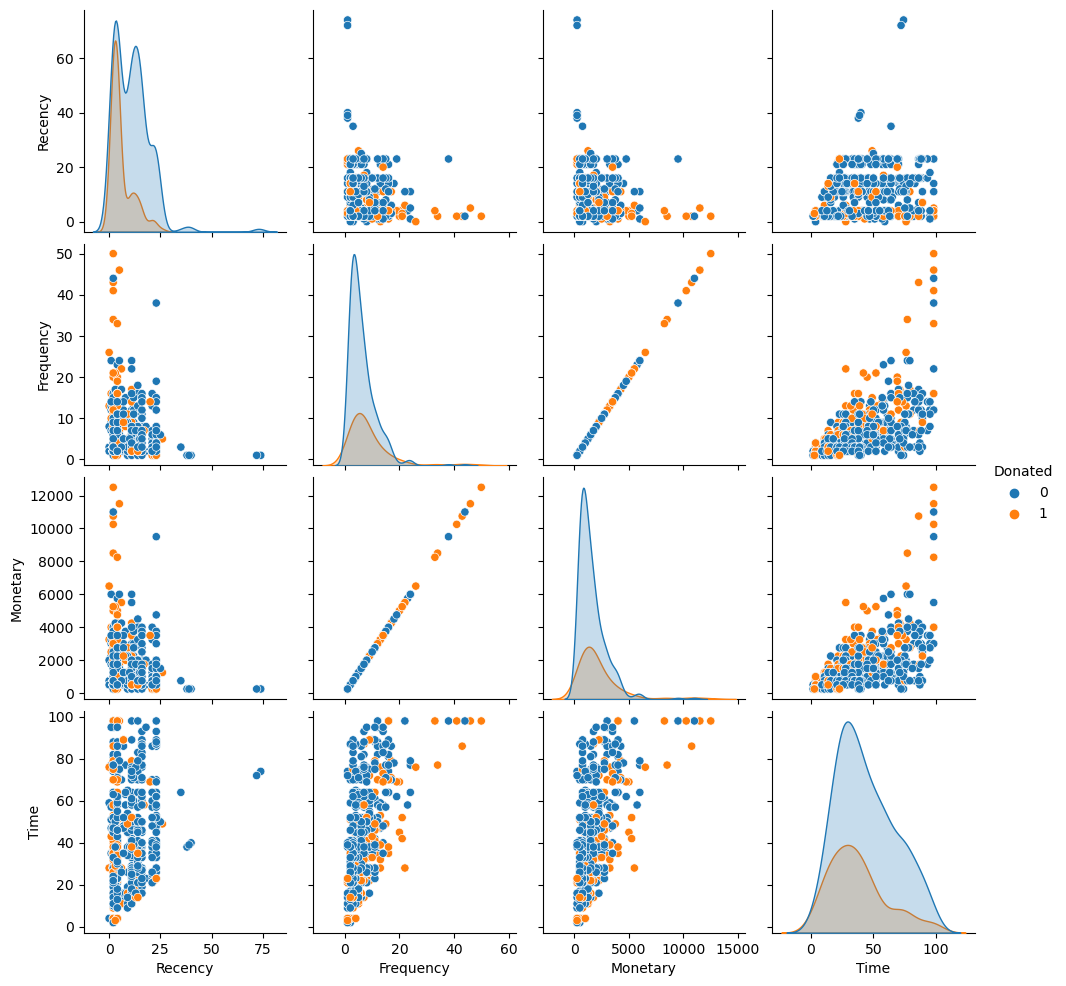

In [7]:
sns.pairplot(df, hue='Donated', diag_kind='kde')

In [8]:
# suspicious correlation. Monetary equals blood donated each time (cc) * Frequency .
(df['Monetary']/df['Frequency']).unique()

array([250.])

In [9]:
# repeated variable must be removed
df=df.drop('Monetary', axis=1)

In [10]:
print('Number of outlier Recency values: ',(df['Recency']>30).sum())

Number of outlier Recency values:  6


In [11]:
# removes rows with outlier recency data
df= df[df['Recency']<30]

In [12]:
# generates new feature, normalizes frequency by number of months since the first donation 
df['Freq_month']=df['Frequency']/df['Time']

In [13]:
df.head()

,Recency,Frequency,Time,Donated,Freq_month
0,2,50,98,1,0.510204
1,0,13,28,1,0.464286
2,1,16,35,1,0.457143
3,2,20,45,1,0.444444
4,1,24,77,0,0.311688


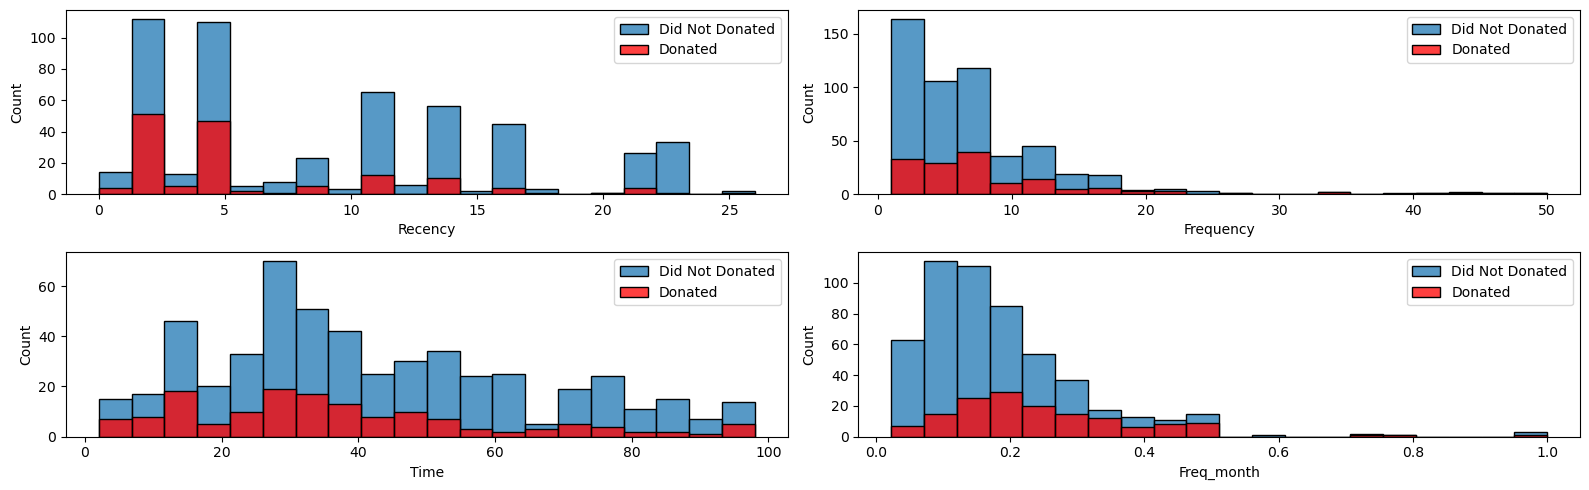

In [14]:
fig, axes= plt.subplots(2,2, figsize=(16,5))
axes=axes.flatten()

for i, col in enumerate (df.drop('Donated', axis=1)):
    sns.histplot(df.loc[:,col], ax=axes[i], bins=20, binrange=[min(df[col]),max(df[col])], label='Did Not Donated')
    sns.histplot(df.loc[df['Donated']==1,col], ax=axes[i], color='red', bins=20, 
                 binrange=[min(df[col]),max(df[col])], label='Donated')
    axes[i].legend()
plt.tight_layout()

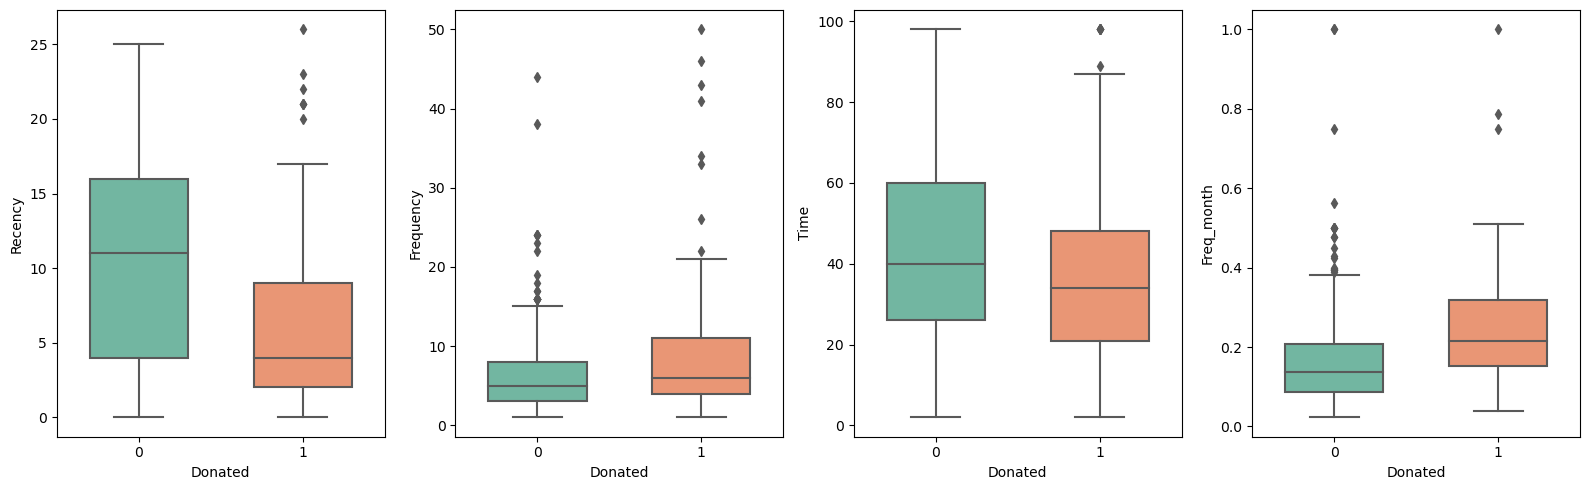

In [15]:
fig, axes= plt.subplots(1,4, figsize=(16,5))

for i, col in enumerate(df.drop('Donated', axis=1)):
    sns.boxplot(x='Donated',y=col, data=df, palette="Set2", order=[0, 1], ax=axes[i], width=0.6)
plt.tight_layout()

In [16]:
# creates predictors and target datasets
X= df.drop('Donated', axis=1)
y=df['Donated']

In [17]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [18]:
# split the data into training and test sets
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.25, stratify=y, random_state=107)

In [19]:
# scale the predictor features based on the training data 
scaler=StandardScaler()
scaler.fit(X_train)

X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

In [20]:
# fits the model- KNN was used as it is less impacted by imbalnce in the data compared to other classifiers
knn=KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7)

In [21]:
# confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, knn.predict(X_test))

array([[78, 17],
       [26, 11]])

In [22]:
from imblearn.combine import SMOTETomek

In [24]:
# oversampling the data
smt = SMOTETomek(sampling_strategy='auto', random_state=105)
X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)

In [25]:
# fit the model to new datasets
svc=SVC(probability=True)

svc.fit(X_train_smt, y_train_smt)

SVC(probability=True)

In [26]:
confusion_matrix(y_test, svc.predict(X_test))

array([[77, 18],
       [15, 22]])

In [27]:
from sklearn.metrics import accuracy_score

print ('Accuracy (imbalanced dataset): {:2.2%}'.format(accuracy_score(y_test, knn.predict(X_test))))
print ('Accuracy (balanced dataset): {:2.2%}'.format(accuracy_score(y_test, svc.predict(X_test))))

Accuracy (imbalanced dataset): 67.42%
Accuracy (balanced dataset): 75.00%


In [28]:
from sklearn.metrics import recall_score

print ('Recall: {:2.2%}'.format(recall_score(y_test, svc.predict(X_test))))

Recall: 59.46%


In [29]:
from sklearn.metrics import precision_score

In [30]:
print ('Precision: {:2.2%}'.format(precision_score(y_test, svc.predict(X_test))))

Precision: 55.00%


In [31]:
from sklearn.metrics import f1_score

In [32]:
print ('f1_score: {:2.2}'.format(f1_score(y_test, svc.predict(X_test))))

f1_score: 0.57


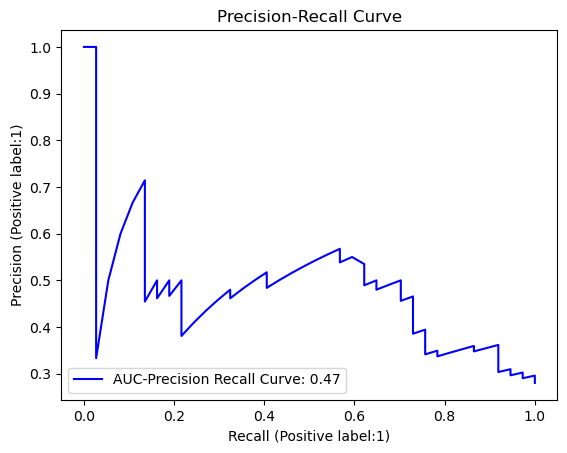

In [33]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, svc.predict_proba(X_test)[:,1])

auc_rp = auc(recall, precision)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='blue', label="AUC-Precision Recall Curve: {:.2}".format(auc_rp))

ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision (Positive label:1)')
ax.set_xlabel('Recall (Positive label:1)')
plt.legend(loc="lower left")
plt.show()

In [34]:
from sklearn.metrics import roc_curve, roc_auc_score

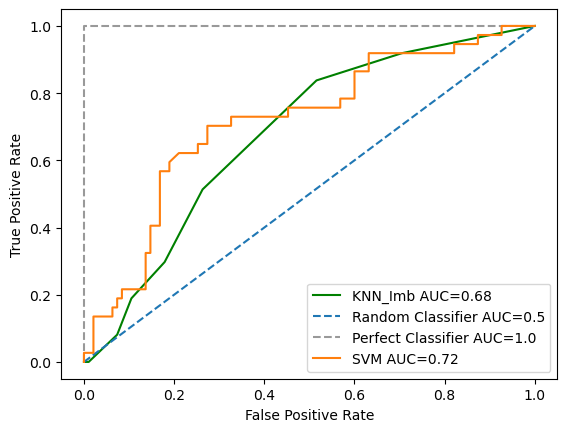

In [35]:
# fpr: false positive rate, tpr=true positive rate
auc_svc = roc_auc_score(y_test, svc.predict_proba(X_test)[:,1])

fpr_svc, tpr_svc, _ = roc_curve(y_test,  svc.predict_proba(X_test)[:,1])

# random classifier. A classifier with no skill. Only predicts 0 for all samples
random_probs = [0 for _ in range(len(y_test))]
auc_random = roc_auc_score(y_test, random_probs)
fpr_rn, tpr_rn, _ = roc_curve(y_test, random_probs)

# classifier trained on imbalanced dataset
auc_knn = roc_auc_score(y_test, knn.predict_proba(X_test)[:,1])

fpr_knn, tpr_knn, _ = roc_curve(y_test,  knn.predict_proba(X_test)[:,1])

# perfect classifier. predicting all samples correctly
auc_perfect = roc_auc_score(y_test, y_test)
fpr_pr, tpr_pr, _ = roc_curve(y_test, y_test)


#create ROC curve
plt.plot(fpr_knn,tpr_knn,label="KNN_Imb AUC={:.2}".format(auc_knn), color='green')
plt.plot(fpr_rn, tpr_rn, linestyle='--', label='Random Classifier AUC={:.2}'.format(auc_random))
plt.plot(fpr_pr, tpr_pr, linestyle='--',color='black', alpha=0.4, label='Perfect Classifier AUC={:.2}'.format(auc_perfect))
plt.plot(fpr_svc,tpr_svc,label="SVM AUC={:.2}".format(auc_svc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [37]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score


In [38]:
# Predictions
y_pred = knn.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

In [39]:
# True Positive (TP), False Positive (FP), True Negative (TN), False Negative (FN)
TP = cm[1, 1]
FP = cm[0, 1]
TN = cm[0, 0]
FN = cm[1, 0]

In [61]:
# Sensitivity (Recall)
print("sensitivity =", TP / (TP + FN))


sensitivity = 0.2972972972972973


In [62]:
# Specificity
print("specificity =", TN / (TN + FP))

specificity = 0.8210526315789474


In [63]:
# Precision
print("precision =", precision_score(y_test, y_pred))

precision = 0.39285714285714285


In [64]:
# Recall
print("recall =", recall_score(y_test, y_pred))

recall = 0.2972972972972973


In [65]:
# True Positive Rate (TPR)
print("tpr =", sensitivity)

tpr = 0.2972972972972973


In [66]:
# False Positive Rate (FPR)
print("fpr =", FP / (FP + TN))

fpr = 0.17894736842105263


In [67]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

# Predictions
y_pred = knn.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# True Positive (TP), False Positive (FP), True Negative (TN), False Negative (FN)
TP = cm[1, 1]
FP = cm[0, 1]
TN = cm[0, 0]
FN = cm[1, 0]

# Sensitivity (Recall)
sensitivity = TP / (TP + FN)

# Specificity
specificity = TN / (TN + FP)

# Precision
precision = precision_score(y_test, y_pred)

# Recall
recall = recall_score(y_test, y_pred)

# True Positive Rate (TPR)
tpr = sensitivity

# False Positive Rate (FPR)
fpr = FP / (FP + TN)

print("Sensitivity (Recall): {:.4f}".format(sensitivity))
print("Specificity: {:.4f}".format(specificity))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("True Positive Rate (TPR): {:.4f}".format(tpr))
print("False Positive Rate (FPR): {:.4f}".format(fpr))


Sensitivity (Recall): 0.2973
Specificity: 0.8211
Precision: 0.3929
Recall: 0.2973
True Positive Rate (TPR): 0.2973
False Positive Rate (FPR): 0.1789
